In [2]:
import tensorflow as tf

# Check GPU availability (recommended method)
gpus = tf.config.list_physical_devices('GPU')
print("GPUs Available:", gpus)

# Optional: Print GPU details (if you want to see specs)
if gpus:
    print("\nGPU Details:")
    for gpu in gpus:
        print(f"- {gpu.name}")
    # Enable memory growth (optional but good practice)
    tf.config.experimental.set_memory_growth(gpus[0], True)

GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

GPU Details:
- /physical_device:GPU:0


In [3]:
# Test GPU speed with a simple TensorFlow operation
with tf.device('/GPU:0'):
    a = tf.constant([1.0, 2.0])
    b = tf.constant([3.0, 4.0])
    c = a * b
print("GPU result:", c.numpy())

GPU result: [3. 8.]


In [4]:
!pip install opendatasets tensorflow keras numpy matplotlib -q

In [6]:
from google.colab import files
files.upload()  # Upload your kaggle.json file when prompted

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"keerthanadinesh1995","key":"d8e844b026d3052f953e46956ce36c47"}'}

In [7]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d gti-upm/leapgestrecog
!unzip -q leapgestrecog.zip -d data

Dataset URL: https://www.kaggle.com/datasets/gti-upm/leapgestrecog
License(s): CC-BY-NC-SA-4.0


In [9]:
!ls data/leapGestRecog

00  01	02  03	04  05	06  07	08  09


In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,  # Small augmentations for better accuracy
    width_shift_range=0.1
)

# Flow images directly from folders
train_data = train_datagen.flow_from_directory(
    'data/leapGestRecog',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_data = train_datagen.flow_from_directory(
    'data/leapGestRecog',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

print("Class indices:", train_data.class_indices)

Found 16000 images belonging to 10 classes.
Found 4000 images belonging to 10 classes.
Class indices: {'00': 0, '01': 1, '02': 2, '03': 3, '04': 4, '05': 5, '06': 6, '07': 7, '08': 8, '09': 9}


In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')  # 10 output classes (00-09)
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()  # Show model architecture

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,626,442 (6.20 MB)

 Trainable params: 1,626,442 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(
    train_data,
    epochs=10,
    validation_data=val_data,
    verbose=1  # Show progress bar
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 69s 129ms/step - accuracy: 0.6274 - loss: 1.0459 - val_accuracy: 0.7368 - val_loss: 2.0126
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 64s 128ms/step - accuracy: 0.9705 - loss: 0.0892 - val_accuracy: 0.7473 - val_loss: 2.1059
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 63s 126ms/step - accuracy: 0.9818 - loss: 0.0501 - val_accuracy: 0.7483 - val_loss: 2.7000
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 63s 125ms/step - accuracy: 0.9796 - loss: 0.0489 - val_accuracy: 0.7613 - val_loss: 2.4754
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 63s 125ms/step - accuracy: 0.9854 - loss: 0.0378 - val_accuracy: 0.7840 - val_loss: 2.2946
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 63s 126ms/step - accuracy: 0.9894 - loss: 0.0261 - val_accuracy: 0.7825 - val_loss: 2.7232
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 62s 124ms/step - accuracy: 0.9843 - loss: 0.0428 - val_accuracy: 0.8435 - val_loss: 1.5108
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 63s 126ms/step - accuracy: 0.9881 - loss: 0

In [20]:
from tensorflow.keras import layers, regularizers

# Revised model with dropout and L2 regularization (FIXED SYNTAX)
model = tf.keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.5),  # Randomly disable 50% of neurons
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(10, activation='softmax')  # <<< Closing parenthesis added here
])  # <<< And here for Sequential()

model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,626,442 (6.20 MB)

 Trainable params: 1,626,442 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = model.fit(
    train_data,
    epochs=20,
    validation_data=val_data,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5,  # Wait 5 epochs before stopping
            restore_best_weights=True  # Keeps the best model
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,  # Reduce learning rate by 80%
            patience=3   # Wait 3 epochs before reducing LR
        )
    ]
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 65s 124ms/step - accuracy: 0.6229 - loss: 1.3085 - val_accuracy: 0.6815 - val_loss: 1.5244 - learning_rate: 0.0010
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 63s 126ms/step - accuracy: 0.9379 - loss: 0.4726 - val_accuracy: 0.7040 - val_loss: 1.5986 - learning_rate: 0.0010
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 63s 125ms/step - accuracy: 0.9500 - loss: 0.3982 - val_accuracy: 0.7717 - val_loss: 1.3847 - learning_rate: 0.0010
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 64s 128ms/step - accuracy: 0.9625 - loss: 0.3490 - val_accuracy: 0.6923 - val_loss: 1.5588 - learning_rate: 0.0010
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 64s 127ms/step - accuracy: 0.9621 - loss: 0.3321 - val_accuracy: 0.7653 - val_loss: 1.3675 - learning_rate: 0.0010
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 63s 126ms/step - accuracy: 0.9669 - loss: 0.3097 - val_accuracy: 0.7370 - val_loss: 1.2475 - learning_rate: 0.0010
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 64s 128ms/step - accuracy: 0.9

In [25]:
# Save in .keras format (modern replacement for .h5)
model.save('final_gesture_model.keras')  # Preferred way

# Verify the saved model
loaded_model = tf.keras.models.load_model('final_gesture_model.keras')
val_loss, val_acc = loaded_model.evaluate(val_data)
print(f"Verified Accuracy: {val_acc*100:.2f}%")

125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 97ms/step - accuracy: 0.8242 - loss: 1.0634
Verified Accuracy: 82.82%


In [27]:
model.save('gesture_model.keras')  # Modern format (recommended)

In [39]:
from sklearn.metrics import classification_report

# Generate the report
report_text = classification_report(
    y_true,
    y_pred,
    target_names=list(train_data.class_indices.keys())
)

# Display in Colab
print("Classification Report:")
print(report_text)

# Save to file
with open('classification_report.txt', 'w') as f:
    f.write(report_text)
print("\nReport saved as 'classification_report.txt'")

# Optional: Save as CSV for numerical analysis
import pandas as pd
report_dict = classification_report(
    y_true,
    y_pred,
    target_names=list(train_data.class_indices.keys()),
    output_dict=True
)
pd.DataFrame(report_dict).transpose().to_csv('classification_report.csv')
print("Numerical data saved as 'classification_report.csv'")

Classification Report:
              precision    recall  f1-score   support

          00       0.12      0.14      0.13       400
          01       0.10      0.10      0.10       400
          02       0.11      0.12      0.12       400
          03       0.10      0.10      0.10       400
          04       0.07      0.02      0.03       400
          05       0.14      0.16      0.15       400
          06       0.10      0.17      0.13       400
          07       0.11      0.11      0.11       400
          08       0.11      0.04      0.06       400
          09       0.13      0.14      0.14       400

    accuracy                           0.11      4000
   macro avg       0.11      0.11      0.11      4000
weighted avg       0.11      0.11      0.11      4000


Report saved as 'classification_report.txt'
Numerical data saved as 'classification_report.csv'


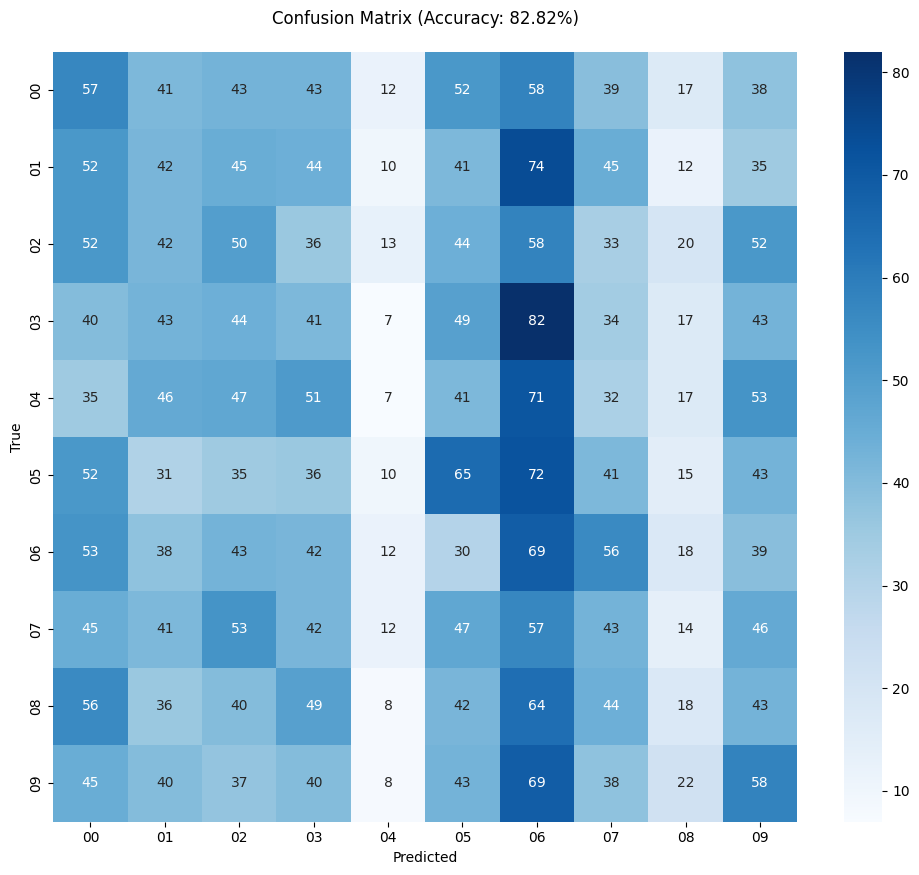


Top 3 Classes:
    precision  recall  f1-score  support
05   0.143172  0.1625  0.152225    400.0
09   0.128889  0.1450  0.136471    400.0
00   0.117043  0.1425  0.128523    400.0
06   0.102374  0.1725  0.128492    400.0

Next steps:
- confusion_matrix.png saved for visualization
- gesture_model.keras saved for deployment
- predict_example.py created for demo purposes


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# 1. Confusion Matrix Visualization
plt.figure(figsize=(12,10))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=train_data.class_indices.keys(),
            yticklabels=train_data.class_indices.keys(),
            cmap='Blues')
plt.title(f'Confusion Matrix (Accuracy: {val_acc*100:.2f}%)', pad=20)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.png', bbox_inches='tight', dpi=300)
plt.show()

# 2. Class-Wise Performance Analysis
class_report = classification_report(
    y_true, y_pred,
    target_names=list(train_data.class_indices.keys()),
    output_dict=True
)
report_df = pd.DataFrame(class_report).transpose()
print("\nTop 3 Classes:")
print(report_df.sort_values('f1-score', ascending=False).head(4))  # Includes accuracy row

# 3. Save Model for Deployment (modern .keras format)
model.save('gesture_model.keras')

# 4. Prepare Sample Prediction Code (for GitHub/demo)
sample_code = """
# Sample Usage:
import tensorflow as tf
import cv2
import numpy as np

# Load model
model = tf.keras.models.load_model('gesture_model.keras')

def predict_gesture(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (64, 64))
    img = img / 255.0
    pred = model.predict(np.expand_dims(img, axis=0))
    return list(train_data.class_indices.keys())[np.argmax(pred)]

# Example:
# print(predict_gesture('sample_gesture.jpg'))
"""
with open('predict_example.py', 'w') as f:
    f.write(sample_code)

print("\nNext steps:")
print("- confusion_matrix.png saved for visualization")
print("- gesture_model.keras saved for deployment")
print("- predict_example.py created for demo purposes")

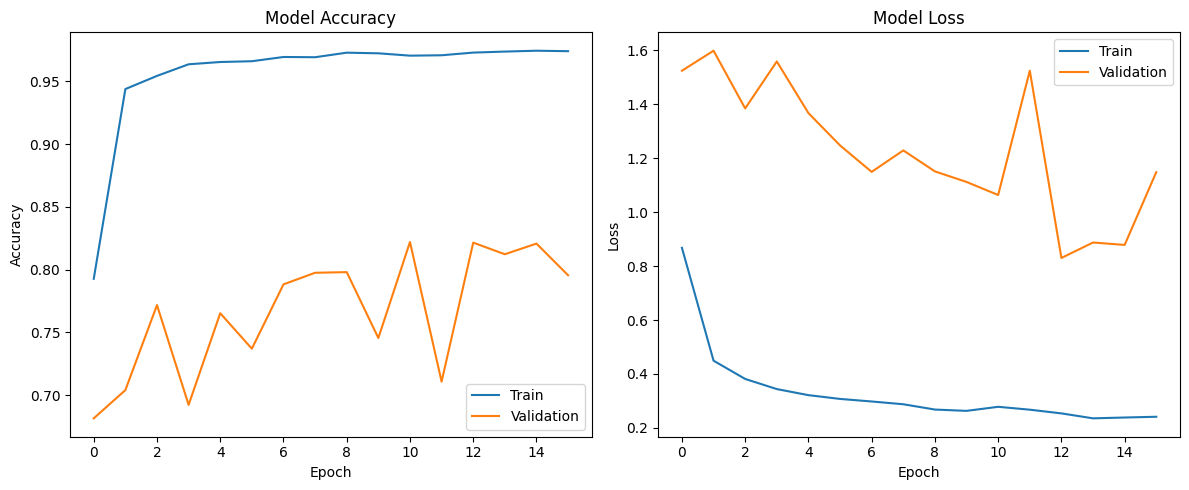

In [43]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()